# Search path data collection

Here we are getting the data required to understand when pyramidal cells fire during the search path (from entering the arena to arriving at the lever).

We exclude the time at the lever from the path. Thus we want to use the "searchToLeverPath" journeys.





In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:08<00:00,  4.41it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)
prepareSessionsForSpatialAnalysisProject(sSesList,myProjectWithTrials.sessionList,pose_file_extension = ".pose_kf.npy")

Loading: /adata/projects/autopi_ca1/results/myProjectWithTrials.pickle
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:27<00:00,  1.42it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict
CPU times: user 14.6 s, sys: 4.13 s, total: 18.8 s
Wall time: 41.2 s


Plot all the searchToLeverPath 

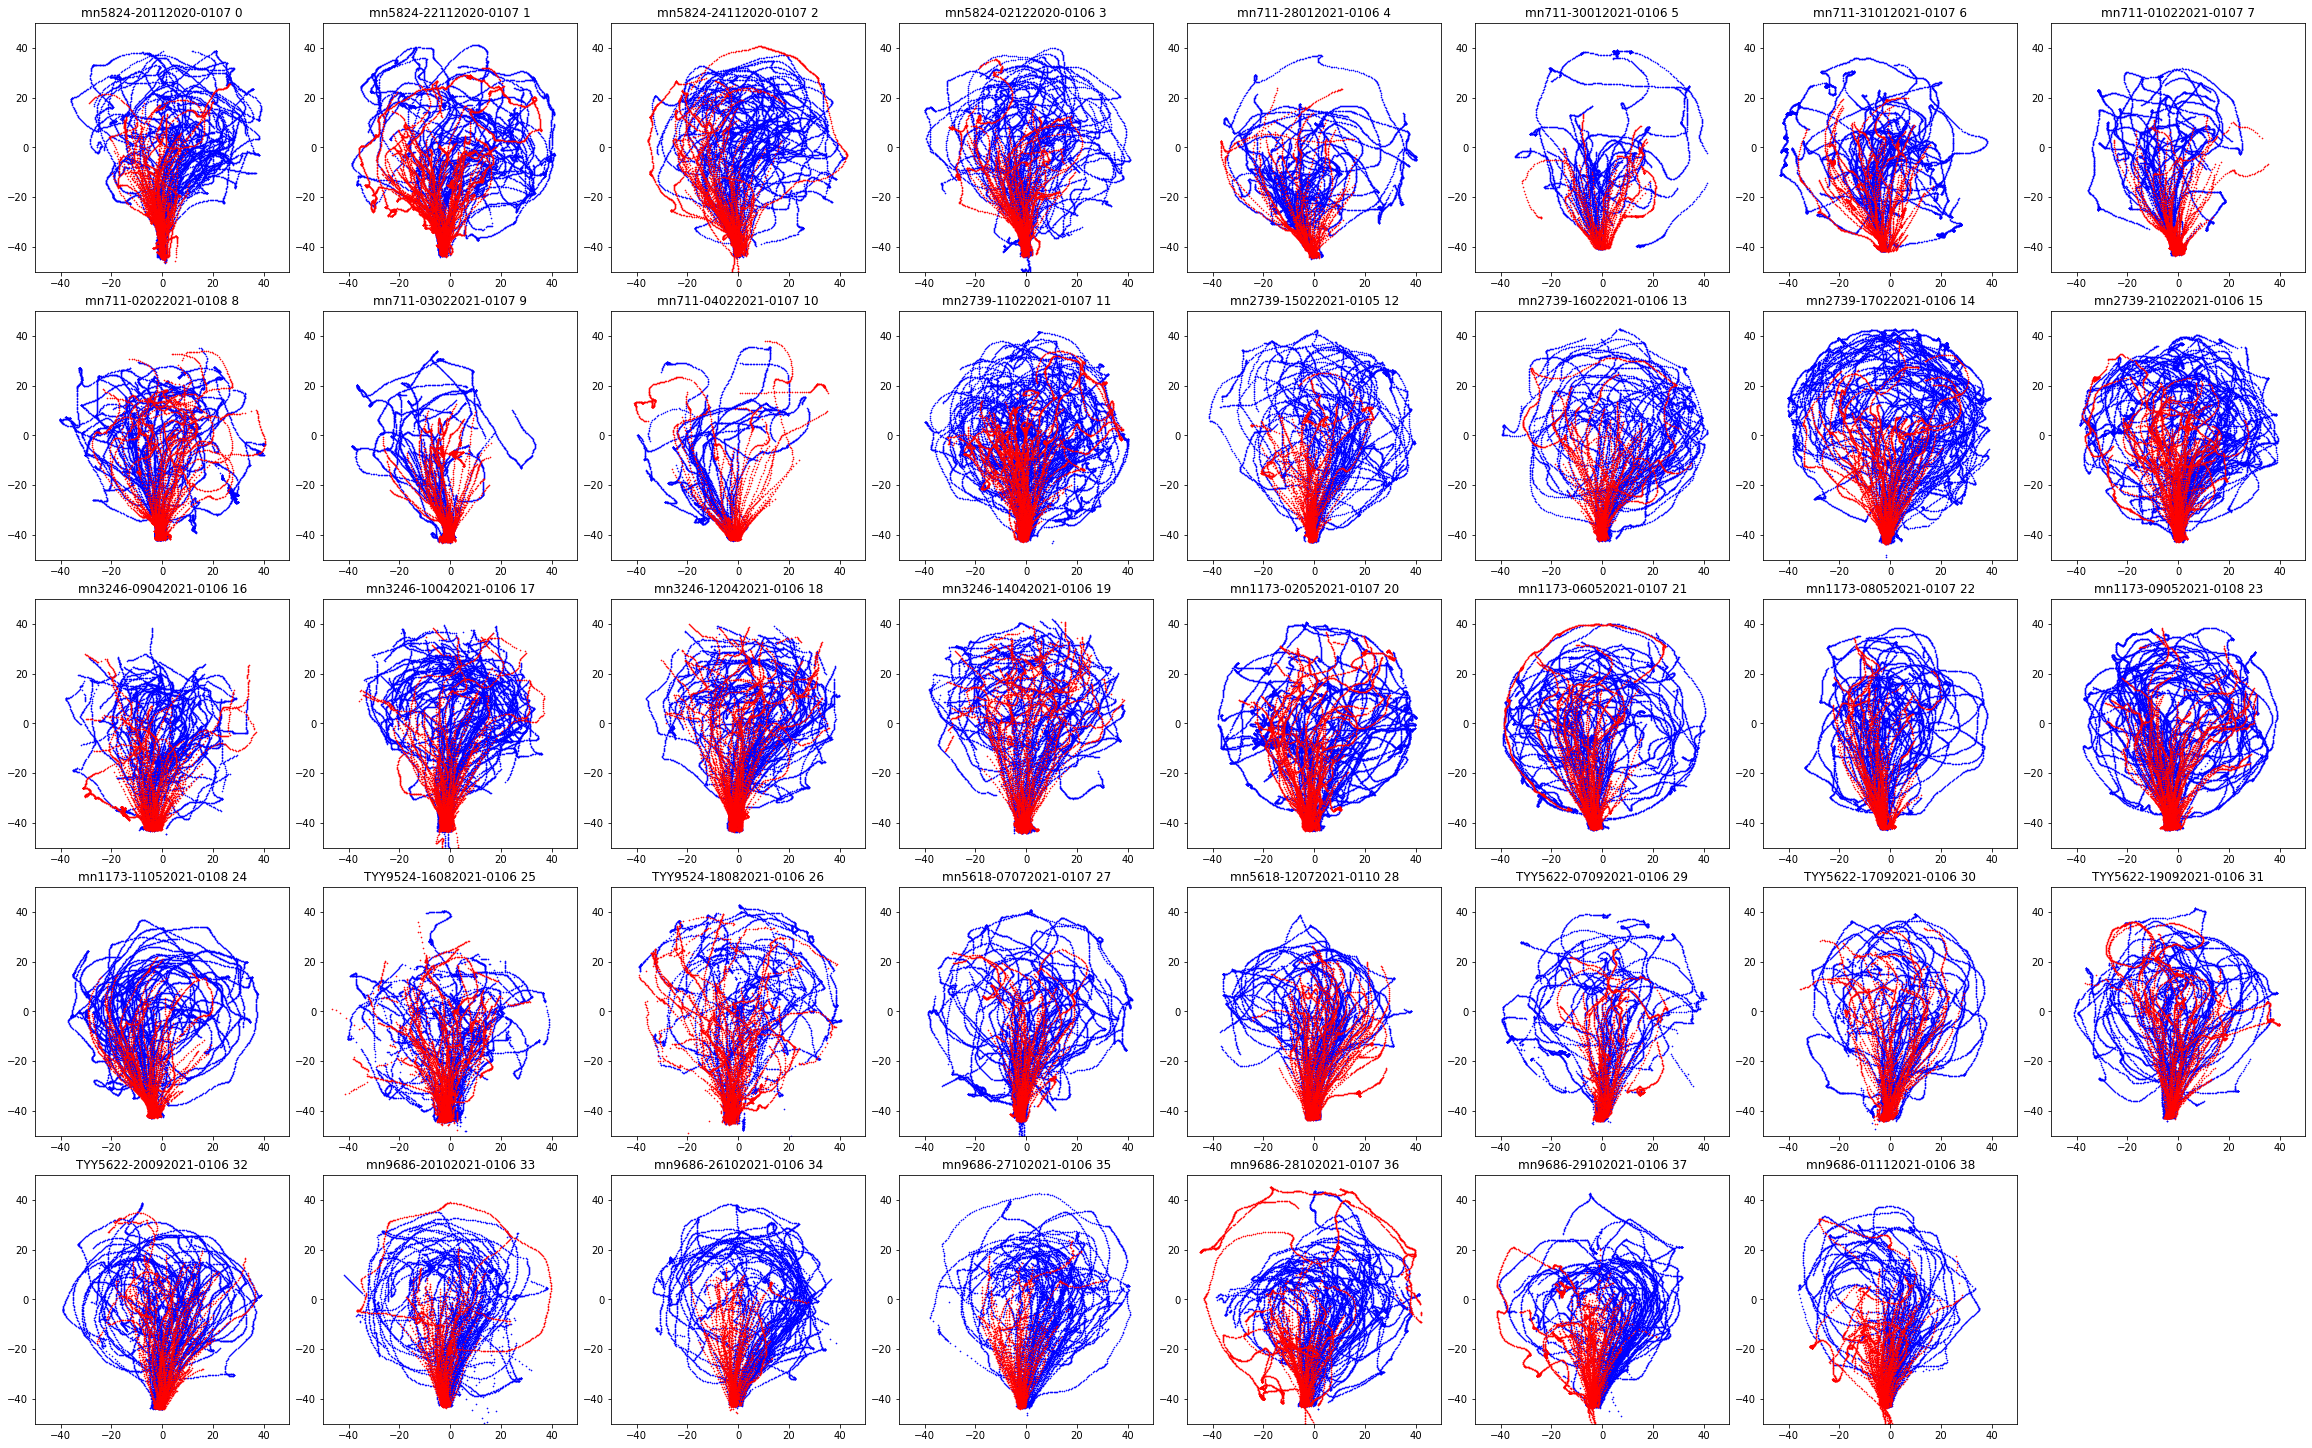

In [3]:
sizePerCol=4
sizePerRow=4
col = 8
row = 5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig)


for i in range(len(sSesList)):
    y = int(i%col)
    x = int(i/col)
    ax = fig.add_subplot(gs[x,y])
    sSes = sSesList[i]
    ses = myProjectWithTrials.sessionList[i]
    getSearchHomingIntervals(ses,sSes)
    ifr, navs, inav = load_ifr_behavior(ses)
    sSes.ap.set_intervals(ses.intervalDict["searchToLeverPath_light"])
    ax.scatter(sSes.ap.pose[:,1],sSes.ap.pose[:,2],s=0.4,color="red",zorder=1)
    sSes.ap.set_intervals(ses.intervalDict["searchToLeverPath_dark"])
    ax.scatter(sSes.ap.pose[:,1],sSes.ap.pose[:,2],s=0.4,color="blue",zorder=0)
    
    
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    ax.set_title(sSes.name+" {}".format(i))
plt.show()

We want to visualize the path to see what we are dealing with.

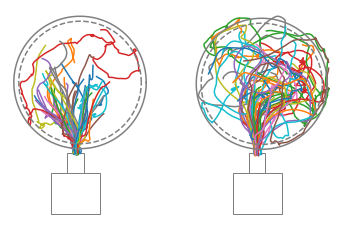

In [4]:
sSes = sSesList[1]
ses = myProjectWithTrials.sessionList[1]
navPathType="searchToLeverPath"
sizePerCol=2
sizePerRow=2
col = 1
row = 1
fig,axes = plt.subplots(1,2)

for i,light in enumerate(["light","dark"]):
    ses.plotNavPath(ax=axes[i],navPathType=navPathType,light=light)


## Firing rate maps

We want the firing rate maps for the search paths

In [5]:
def getMaps(ses,sSes,onlyArena=False):
    """
    Get all the maps of the data within the intervals of interest
    """
    
    xy_range=np.array([[-50,-50],[50,50]])
    
    # get all the conditions we are interested
    conditionDicts = [{"type" : "searchToLeverPath", "light" : "light"},
                      {"type" : "searchToLeverPath", "light" : "light_1"},
                      {"type" : "searchToLeverPath", "light" : "light_2"},
                      {"type" : "searchToLeverPath", "light" : "dark"},
                      {"type" : "searchToLeverPath", "light" : "dark_1"},
                      {"type" : "searchToLeverPath", "light" : "dark_2"}]
    res = {}
    for d in conditionDicts:
    
        navPathType= d["type"]
        light = d["light"]
        inter = ses.intervalDict[navPathType+"_"+light]

        sSes.ap.set_intervals(inter)
        

        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(inter)
            n.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, smoothing=True,minimal_occupancy_sec=0.01, xy_range=xy_range)
    
        mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
        mapStack = np.stack(mapList, axis=0)
        res[navPathType+"_"+light]=mapStack
        
    # reset to original intervals
    sSes.ap.unset_intervals()
        
    return res

In [6]:
res = getMaps(ses,sSes)

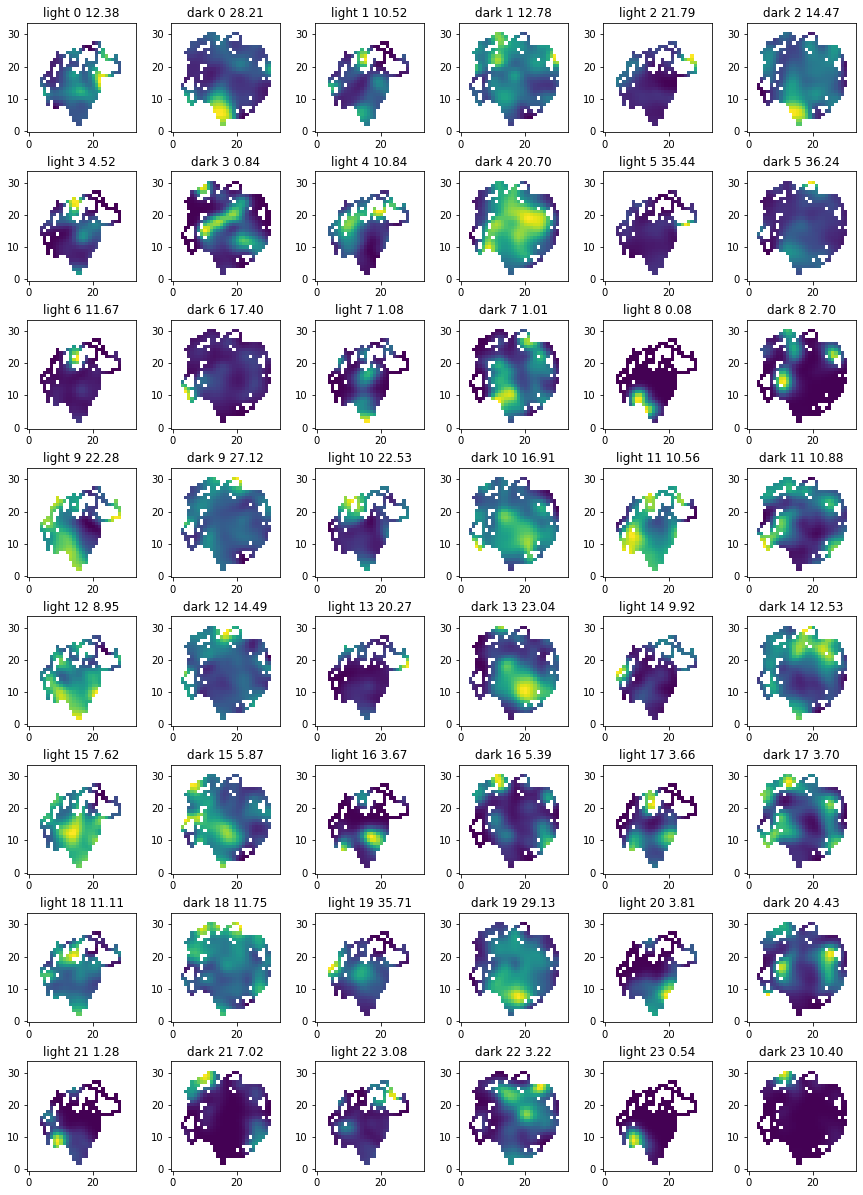

In [7]:
nCells=res["searchToLeverPath_light"].shape[0]
navPathType="searchToLeverPath"
sizePerCol=2
sizePerRow=2
col = 6
row = int(nCells/3)+1

fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig)

for j in range(nCells):
    x = int(j/3)
    y = j%3*2
    for i,light in enumerate(["light","dark"]):   
        ax = fig.add_subplot(gs[x,y+i])
        ax.imshow(res["searchToLeverPath_{}".format(light)][j,:,:].T,origin="lower")
        ax.set_title("{} {} {:.2f}".format(light,j,np.nanmax(res["searchToLeverPath_{}".format(light)][j,:,:]))) 

In [8]:
%%time
res = [ getMaps(ses,sSes) for ses,sSes in zip(myProjectWithTrials.sessionList[:],sSesList[:])]

CPU times: user 3min 28s, sys: 17.2 s, total: 3min 45s
Wall time: 3min 45s


In [9]:
# reorganize the maps
myDict={}
for k in res[0].keys():
    myDict[k] = np.concatenate([ d[k] for d in res])
myDict['searchToLeverPath_light'].shape

(1268, 34, 34)

In [10]:
# save the maps
fn=myProject.dataPath+"/results/searchMapDict.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myDict, handle)

saving: /adata/projects/autopi_ca1/results/searchMapDict.pickle


In [11]:
fn=myProject.dataPath+"/results/searchMapDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    myMaps=pickle.load(handle)

loading: /adata/projects/autopi_ca1/results/searchMapDict.pickle


# 1D rate histograms of the search path and calculate the information score.

We need to take into account 3 variables 

* distance run
* lever distance (target Distance)
* time run
* y coordinate


## Getting the data

These 3 behavioral variables can be extracted from the iNav DataFrame.

We can use the ses.intervalDict[] for the search path to get rid of spikes that are outside of the search paths.

We can take the iNav variable we want an put it in the spikeA.animal_pose object (as the x value). The res time is common to the 2 data sets

We can use the already available methods in spikeA to get info score and firing rate maps.

## 1D histogram binning

We need to have an equivalent binning for the 3 variables to be able to make valid comparisons. We want to compare between the 3 variables and between light and dark trials. 

We can set the number of bins to 20. The minimal values can be set to 0 distance, 0 time and 10 cm distance to lever, -42 for y There are plenty of data at this extrem.
The maximum value should be set to the .90 percentile of either light or dark trials, whichever is the lowest. 
This will get rid of bins with very low occupancy that tend to create spuriously high firing rate values.
The range will kick out the data from search path in darkness with very long paths, to concentrate on the beginning of the path.






In [12]:
def setAnimalPoseFromInav(ses,sSes,navs,inav,pathType="searchToLeverPath",light="light",variableName="distance",aposeColIndex = 1):
    """
    Fill a column of the ap.animal_pose.pose with the values from the iNav data frame
    
    The 2 data sets can be match with the resTime. They should have the same values
    """
    intName = pathType + "_" + light 
    inter = ses.intervalDict[intName]
   # print("setAnimalPoseFromInav inter.shape", inter.shape)
    # set the right intervals in animal pose
    sSes.ap.set_intervals(inter)
    
    # get the path names of the type we want
    navPathNames = navs.name[(navs.type == pathType) & (navs.light == light)]
    # get inav data for the paths we want
    inavSel = inav[inav.name.isin(navPathNames)]

    #print(inavSel.shape,sSes.ap.pose.shape)
    
    
    # check that we have perfect size match 
    if sSes.ap.pose[:,0].shape[0] == inavSel.shape[0]: 
        # if sizes matches, then just copy
        sSes.ap.pose[:,aposeColIndex] = inavSel[variableName].to_numpy()
    
    # different size, we can merge the data frame
    else : #sSes.ap.pose[:,0].shape[0] != inavSel.shape[0] :  
        df = pd.DataFrame({"timeRes":sSes.ap.pose[:,0]})  
        df = pd.merge(df,inavSel[["timeRes",variableName]],on="timeRes",how="left")
        sSes.ap.pose[:,aposeColIndex] = df[variableName].to_numpy()
    
    #print("max:",np.nanmax(sSes.ap.pose[:,aposeColIndex]))

In [13]:
def one_d_rate_histos_stats (ses,sSes, pathType="searchToLeverPath",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"]):
    """
    Create 2 dictionaries containing rate histograms and information scores for the rate histograms
    
    The bins of the histograms are set to always have 15 bins. The range goes from 0, 10 or -40 until the 92.5 percentiles.
    The limited range is required to be able to compare the different variables agains each other, and to be able to compare light and dark trials
    
    """

    getSearchHomingIntervals(ses,sSes)
    ifr, navs, inav = load_ifr_behavior(ses)
    resHisto = {}
    dfStats = pd.DataFrame()
    
    print(ses.name,"Number of neurons:",len(sSes.cg.neuron_list))

    for var in behavioralVariables: 

        # get the right binning based on percentile
        sMax = 100000
        lMin = 0
        for light in ["light","dark"]:

            intName = pathType + "_" + light 
            inter = ses.intervalDict[intName]
            
            setAnimalPoseFromInav(ses,sSes,navs,inav,pathType,light,variableName=var)
            
           
            maxX = np.nanquantile(sSes.ap.pose[:,1],q = .90)
            if maxX < sMax:
                sMax = maxX
                
            if var == "targetDistance":
                lMin = 12 
            elif var == "y":
                lMin = -42.5
            else:
                lMin = 0
            
        
        sMax= np.round(sMax,3)
        lMin = np.round(lMin,3)
        binSize = (sMax-lMin)/nbins
        #print(var, lMin,sMax,nbins,binSize)

        # create the firing rate histograms
        for light in ["light","dark"]:

            intName = pathType + "_" + light 
            setAnimalPoseFromInav(ses,sSes,navs,inav,pathType,light,variableName=var)
            inter = ses.intervalDict[intName]
            
            #print("one_d inter.shape", inter.shape)
            for n in sSes.cg.neuron_list:
                n.spike_train.set_intervals(inter)
                n.spatial_properties.firing_rate_histogram(cm_per_bin=binSize, smoothing_sigma_cm=binSize*1,smoothing=True,x_range=np.array([lMin,sMax]),linspace=True,n_bins=nbins)

            mapList = [ n.spatial_properties.firing_rate_histo for n in sSes.cg.neuron_list ]
            #print(mapList[0].shape)
            mapStack = np.stack(mapList, axis=0)
            resHisto[intName+"_"+var]=mapStack

        # get information score for firing rate histograms
        for light in ["light","dark"]:

            intName = pathType + "_" + light 
            inter = ses.intervalDict[intName]
            setAnimalPoseFromInav(ses,sSes,navs,inav,pathType,light,variableName=var)

            for n in sSes.cg.neuron_list:
                n.spike_train.set_intervals(inter)
                n.spatial_properties.firing_rate_histogram(cm_per_bin=binSize, smoothing_sigma_cm=binSize*1,smoothing=False,x_range=np.array([lMin,sMax]),linspace=True,n_bins=nbins)

            ISList = [ n.spatial_properties.information_score_histogram() for n in sSes.cg.neuron_list ]
            df = pd.DataFrame({"session": ses.name,
                               "cluId": [ ses.name+"_"+n.name for n in sSes.cg.neuron_list ],
                               "light" : light,
                               "behavioralVariable" : var,
                               "meanRate": [n.spike_train.mean_firing_rate() for n in sSes.cg.neuron_list],
                                "info": ISList,
                                "minX": lMin,
                                "maxX": sMax,
                                "peakRate": np.max(resHisto[intName+"_"+var],axis=1),
                                "peakLoc": np.argmax(resHisto[intName+"_"+var],axis=1)})
            dfStats = dfStats.append(df)

    return dfStats, resHisto

In [14]:
sesIndex = 0
sSes = sSesList[sesIndex]
ses = myProjectWithTrials.sessionList[sesIndex]
dfStats, resHisto = one_d_rate_histos_stats(ses,sSes, pathType="searchToLeverPath",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"])
#dfStats, resHisto = one_d_rate_histos_stats(ses,sSes, pathType="searchToLeverPath",nbins = 15, behavioralVariables = ["y"])

mn5824-20112020-0107 Number of neurons: 12


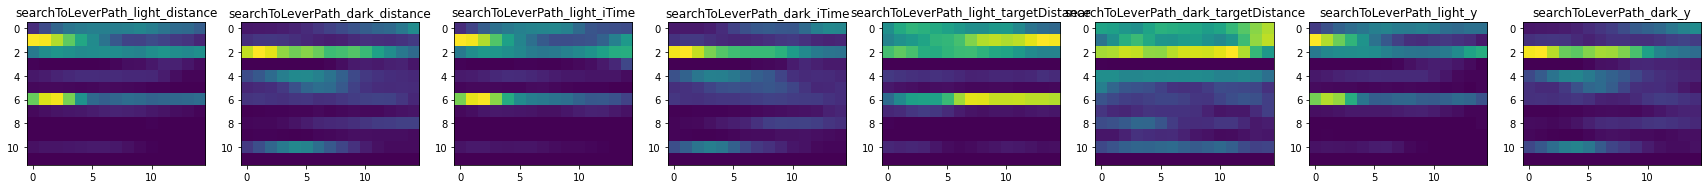

In [15]:
nCond = len(resHisto.keys())
fig, axes = plt.subplots(1,nCond,figsize=(30,10))
        
for i,k in enumerate(resHisto.keys()):
    m = resHisto[k]
    axes[i].imshow(m)
    axes[i].set_title(k)

In [16]:
%%time
res = [ one_d_rate_histos_stats(ses,sSes,pathType="searchToLeverPath",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"]) for ses,sSes in zip(myProjectWithTrials.sessionList[:],sSesList[:])]

mn5824-20112020-0107 Number of neurons: 12
mn5824-22112020-0107 Number of neurons: 24
mn5824-24112020-0107 Number of neurons: 8
mn5824-02122020-0106 Number of neurons: 10
mn711-28012021-0106 Number of neurons: 10
mn711-30012021-0106 Number of neurons: 5
mn711-31012021-0107 Number of neurons: 24
mn711-01022021-0107 Number of neurons: 31
mn711-02022021-0108 Number of neurons: 32
mn711-03022021-0107 Number of neurons: 26
mn711-04022021-0107 Number of neurons: 32
mn2739-11022021-0107 Number of neurons: 7
mn2739-15022021-0105 Number of neurons: 18
mn2739-16022021-0106 Number of neurons: 25
mn2739-17022021-0106 Number of neurons: 20
mn2739-21022021-0106 Number of neurons: 8
mn3246-09042021-0106 Number of neurons: 26
mn3246-10042021-0106 Number of neurons: 36
mn3246-12042021-0106 Number of neurons: 21
mn3246-14042021-0106 Number of neurons: 16
mn1173-02052021-0107 Number of neurons: 30
mn1173-06052021-0107 Number of neurons: 84
mn1173-08052021-0107 Number of neurons: 77
mn1173-09052021-0108 N

In [17]:
dfStats = pd.concat([ s[0] for s in res])

In [18]:
myRes = {}
for k in res[0][1]:
    myRes[k] = np.vstack([(s[1][k])for s in res])
print(myRes.keys())
myRes['searchToLeverPath_light_distance'].shape

dict_keys(['searchToLeverPath_light_distance', 'searchToLeverPath_dark_distance', 'searchToLeverPath_light_iTime', 'searchToLeverPath_dark_iTime', 'searchToLeverPath_light_targetDistance', 'searchToLeverPath_dark_targetDistance', 'searchToLeverPath_light_y', 'searchToLeverPath_dark_y'])


(1268, 15)

In [19]:
fn=myProject.dataPath+"/results/1DsearchHisto.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myRes, handle)

saving: /adata/projects/autopi_ca1/results/1DsearchHisto.pickle


In [20]:
fn=myProject.dataPath+"/results/1DsearchHistoStats.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(dfStats, handle)

saving: /adata/projects/autopi_ca1/results/1DsearchHistoStats.pickle


# IFR during search paths

We want the journey firing rate matrices. We can calculate them for a series of behavioral variables.

* distance
* y-coordinate
* targetDistance
* iTime

## Binning

We could create a matrix that is big enough to include all the data for a cell (with the longest trial). Then, at a later stage, we could just cut the matrix if this is what we want.

We would only need to set the bin size so that it is the same across neurons.



In [21]:
def journeyIFRMatrices(ses,sSes,navPathType="searchToLeverPath",smoothing=True):
    print(ses.name)
    
    # load raw data from file
    ifr, navs, inav = load_ifr_behavior(ses)
    
    # create a list of NeuronAutopi object
    naList=[]
    for i, n in enumerate(sSes.cg.neuron_list):
        neuronIndex=i
        cluId = sSes.name+"_"+n.spike_train.name
        na = NeuronAutopi(name = cluId, ifr = (ifr[0][neuronIndex,:],ifr[1]),navPathSummary=navs,iNavPath=inav,trialElectro=ses.trialList[0])
        naList.append(na)
    
    print("number of neurons:",len(sSes.cg.neuron_list))
    
    selNames = navs[(navs.type == "searchToLeverPath")].name
    inavSel = inav[inav.name.isin(selNames)]
    
    ############################################
    ## get the range that will cover all trials#
    ############################################
    minVals = {"iTime":0,
              "distance":0,
              "targetDistance":12,
              "y": -40}
    maxVals = {}
    for var in ["iTime","distance","targetDistance","y"]:
        ## find the maximal value for this variable
        maxVals[var] = np.nanmax(inavSel[var])
    
    valsPerBins = {"iTime":0.15, # tracking is at 50Hz
              "distance":2,
              "targetDistance":2,
              "y": 2}
    #print(minVals)
    #print(maxVals)
    #print(valsPerBins)
    
    # run the analysis
    for var in ["iTime","distance","targetDistance","y"]:
        for light in ["light","dark"]:
            for i, na in enumerate(naList):
                na.navPathBehavioralMatrix(navPathType=navPathType,light=light,nLeverMin = 1,
                                           behavioralVariable = var,bins=np.arange(minVals[var],maxVals[var],valsPerBins[var]),
                                           smoothing=smoothing,smoothingSigma=2) # per journey
                na.navPathBehavioralHistogram(navPathType=navPathType,light=light,nLeverMin = 1,behavioralVariable = var,bins=np.arange(minVals[var],maxVals[var],valsPerBins[var])) # all journeys together    
    # save the results
    sesRes={}
    for na in naList:
        sesRes[na.name] = na.navPathResultsDict
    
    return sesRes           

In [22]:
%%time
sesIndex = 8
sSes = sSesList[sesIndex]
ses = myProjectWithTrials.sessionList[sesIndex]
ses.name
res  =  journeyIFRMatrices(ses,sSes)

mn711-02022021-0108
number of neurons: 32
CPU times: user 2min 54s, sys: 119 ms, total: 2min 54s
Wall time: 2min 54s


Plot the results so that we don't get surprises later on. Each neuron has 8 plots (4 variables x 2 light conditions)

(53, 133)


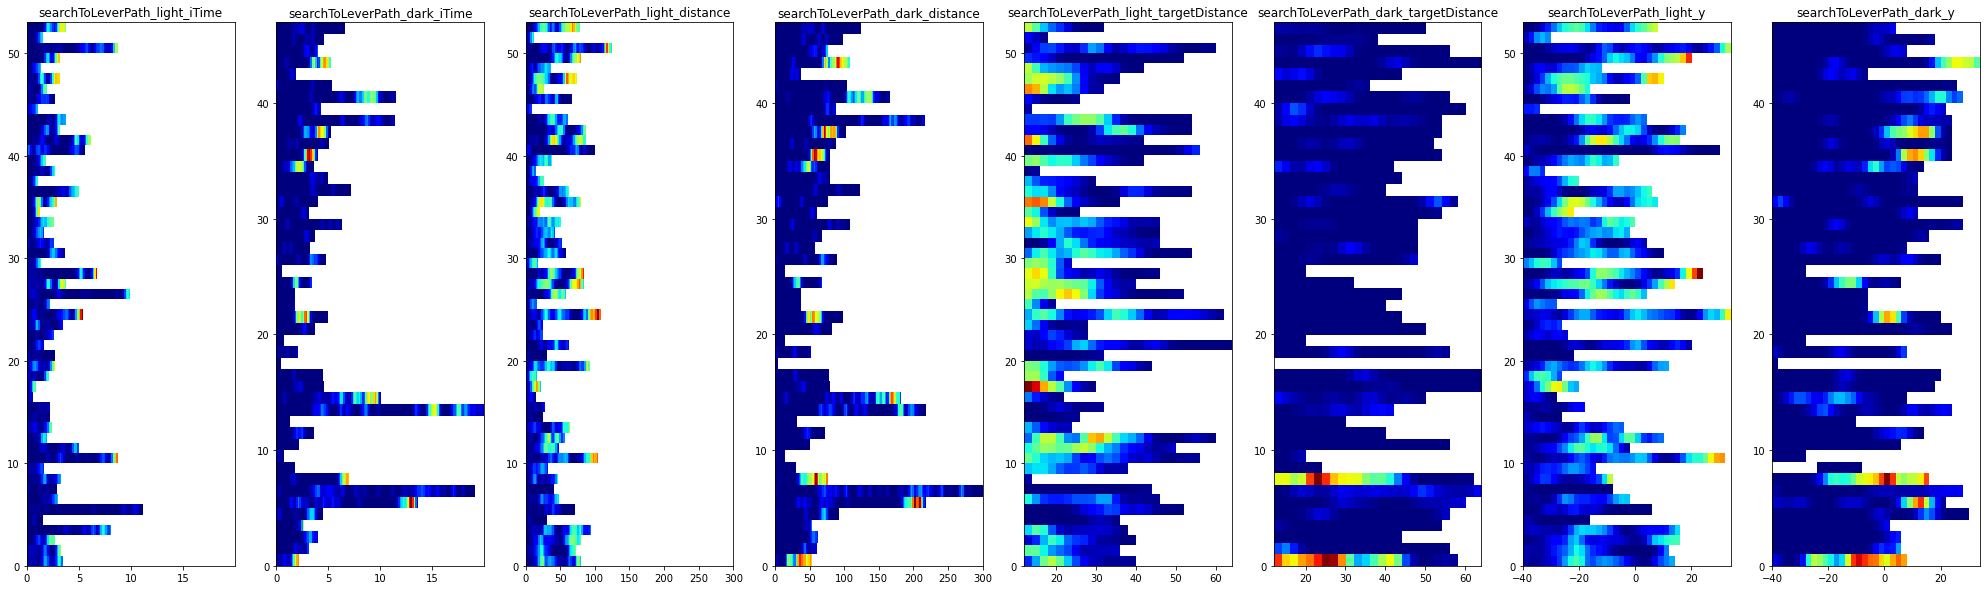

In [23]:
M = res[list(res.keys())[6]]["matrix"]
nCond = len(M.keys())
fig, axes = plt.subplots(1,nCond,figsize=(35,10))
m = M[list(M.keys())[0]]["matrix"]
print(m.shape)

for i,k in enumerate(M.keys()) :
    # reorder the matrix rows according to number of np.nan
    m = M[k]["matrix"]
    
    #axes[i].imshow(M[np.isnan(M).sum(axis=1).argsort()] ,interpolation="none",aspect="auto",extent=[np.min(m[k]["bins"]),np.max(m[k]["bins"]),0,M.shape[0]],origin="lower",cmap="jet")
    axes[i].imshow(m ,interpolation="none",aspect="auto",extent=[np.min(M[k]["bins"]),np.max(M[k]["bins"]),0,m.shape[0]],origin="lower",cmap="jet")
    axes[i].set_title(k)



In [24]:
%%time
res = [ journeyIFRMatrices(ses,sSes) for ses,sSes in zip(myProjectWithTrials.sessionList[:],sSesList[:])]

mn5824-20112020-0107
number of neurons: 12
mn5824-22112020-0107
number of neurons: 24
mn5824-24112020-0107
number of neurons: 8
mn5824-02122020-0106
number of neurons: 10
mn711-28012021-0106
number of neurons: 10
mn711-30012021-0106
number of neurons: 5
mn711-31012021-0107
number of neurons: 24
mn711-01022021-0107
number of neurons: 31
mn711-02022021-0108
number of neurons: 32
mn711-03022021-0107
number of neurons: 26
mn711-04022021-0107
number of neurons: 32
mn2739-11022021-0107
number of neurons: 7
mn2739-15022021-0105
number of neurons: 18
mn2739-16022021-0106
number of neurons: 25
mn2739-17022021-0106
number of neurons: 20
mn2739-21022021-0106
number of neurons: 8
mn3246-09042021-0106
number of neurons: 26
mn3246-10042021-0106
number of neurons: 36
mn3246-12042021-0106
number of neurons: 21
mn3246-14042021-0106
number of neurons: 16
mn1173-02052021-0107
number of neurons: 30
mn1173-06052021-0107
number of neurons: 84
mn1173-08052021-0107
number of neurons: 77
mn1173-09052021-0108
n

In [25]:
newRes={}
for d in res:
    newRes.update(d)
print("Number of neurons: {}".format(len(newRes)))

Number of neurons: 1268


In [26]:
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(newRes, handle)

saving: /adata/projects/autopi_ca1/results/searchIFRDict.pickle


In [27]:
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
with open(fn, 'rb') as handle:
    searchIFR = pickle.load(handle)